In [3]:
# ========== IMPORT ==========
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = pd.read_csv('spam-2.csv')
data

,Kategori,Pesan
0,spam,Secara alami tak tertahankan identitas perusah...
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak..."
...,...,...
2631,ham,Pengingat halo semuanya: Vince telah meminta s...
2632,ham,Re: Argentina Power & Gas Market Modeling Oke ...
2633,ham,"Re: Program Enron / Stanford Stinson, hebat! S..."
2634,ham,"Persetujuan untuk peninjau Roberts JR, Michael..."


In [5]:
def preprocessing(text):
    # case folding
    text = text.lower()

    # remove punctuation and non-alphabetic characters
    text = re.sub(r'[^\w\s]', '', text)

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # stopword removal
    factory = StopWordRemoverFactory()
    stopwords = factory.get_stop_words()
    words = text.split()
    text = " ".join([word for word in words if word not in stopwords])

    return text
data

,Kategori,Pesan
0,spam,Secara alami tak tertahankan identitas perusah...
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak..."
...,...,...
2631,ham,Pengingat halo semuanya: Vince telah meminta s...
2632,ham,Re: Argentina Power & Gas Market Modeling Oke ...
2633,ham,"Re: Program Enron / Stanford Stinson, hebat! S..."
2634,ham,"Persetujuan untuk peninjau Roberts JR, Michael..."


In [6]:
data['Pesan'] = data['Pesan'].apply(preprocessing)
data

,Kategori,Pesan
0,spam,alami tak tertahankan identitas perusahaan san...
1,spam,fanny gunslinger perdagangan saham merrill muz...
2,spam,rumah rumah baru luar biasa menjadi mudah menu...
3,spam,permintaan khusus pencetakan warna informasi t...
4,spam,jangan punya uang dapatkan cd perangkat lunak ...
...,...,...
2631,ham,pengingat halo semuanya vince meminta mengirim...
2632,ham,re argentina power gas market modeling oke jul...
2633,ham,re program enron stanford stinson hebat menant...
2634,ham,persetujuan peninjau roberts jr michael a meny...


In [7]:
Le = LabelEncoder()
data['Kategori'] = Le.fit_transform(data['Kategori'])
data

,Kategori,Pesan
0,1,alami tak tertahankan identitas perusahaan san...
1,1,fanny gunslinger perdagangan saham merrill muz...
2,1,rumah rumah baru luar biasa menjadi mudah menu...
3,1,permintaan khusus pencetakan warna informasi t...
4,1,jangan punya uang dapatkan cd perangkat lunak ...
...,...,...
2631,0,pengingat halo semuanya vince meminta mengirim...
2632,0,re argentina power gas market modeling oke jul...
2633,0,re program enron stanford stinson hebat menant...
2634,0,persetujuan peninjau roberts jr michael a meny...


In [8]:

X_raw = data['Pesan'].tolist()
y = torch.tensor(data['Kategori'].values).float().unsqueeze(1)


In [9]:
from collections import defaultdict

# Tokenisasi dan vocab
tokenized = [x.split() for x in X_raw]
word2idx = defaultdict(lambda: len(word2idx))
word2idx['<PAD>']  # index 0 untuk padding

for tokens in tokenized:
    for token in tokens:
        word2idx[token]

word2idx = dict(word2idx)  # freeze vocab

vocab_size = len(word2idx)
max_len = 100  # dibatasi

# Encoding + Padding
encoded = []
for tokens in tokenized:
    ids = [word2idx.get(word, 0) for word in tokens[:max_len]]
    ids += [0] * (max_len - len(ids))
    encoded.append(ids)

X = torch.tensor(encoded)


In [10]:
X

tensor([[    1,     2,     3,  ...,    44,    81,    22],
        [  100,   101,   102,  ...,     0,     0,     0],
        [  143,   143,   144,  ...,     0,     0,     0],
        ...,
        [ 1306,  1735, 15531,  ...,     0,     0,     0],
        [  164,  2414,  4944,  ...,     0,     0,     0],
        [ 1306,  4544, 19972,  ...,     0,     0,     0]])

In [11]:
y

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [12]:
# Split train/test
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 32
train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


In [13]:
class SpamDetection(nn.Module):
    def __init__(self, vocab_size, embed_dim,  hidden_dim):
        super(SpamDetection, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim,  hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear( hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1]  # shape: (batch, hidden)
        x = self.dropout(h_n)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [14]:
model = SpamDetection(vocab_size, embed_dim=120, hidden_dim=120)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (output > 0.5).float()
        correct += (preds == batch_y).float().sum().item()

    acc = correct / len(X_train)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2%}")


Epoch 1, Loss: 42.4297, Accuracy: 63.19%
Epoch 2, Loss: 33.2447, Accuracy: 78.46%
Epoch 3, Loss: 13.3850, Accuracy: 92.74%
Epoch 4, Loss: 5.1625, Accuracy: 98.01%
Epoch 5, Loss: 2.2506, Accuracy: 99.10%
Epoch 6, Loss: 1.1171, Accuracy: 99.67%
Epoch 7, Loss: 0.6818, Accuracy: 99.76%
Epoch 8, Loss: 0.4099, Accuracy: 99.91%
Epoch 9, Loss: 0.2586, Accuracy: 99.95%
Epoch 10, Loss: 0.3583, Accuracy: 99.91%


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
model.eval()
with torch.no_grad():
    output = model(X_test)
    preds = (output > 0.5).float()

# Konversi ke NumPy
y_true = y_test.squeeze().numpy()
y_pred = preds.squeeze().numpy()

# Hitung metrik
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nAkurasi   : {acc:.2%}")
print(f"Presisi   : {prec:.2%}")
print(f"Recall    : {rec:.2%}")
print(f"F1-score  : {f1:.2%}")

# (Opsional) laporan lengkap
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Bukan Spam", "Spam"]))



Akurasi   : 94.51%
Presisi   : 96.83%
Recall    : 92.08%
F1-score  : 94.39%

Classification Report:
              precision    recall  f1-score   support

  Bukan Spam       0.92      0.97      0.95       263
        Spam       0.97      0.92      0.94       265

    accuracy                           0.95       528
   macro avg       0.95      0.95      0.95       528
weighted avg       0.95      0.95      0.95       528



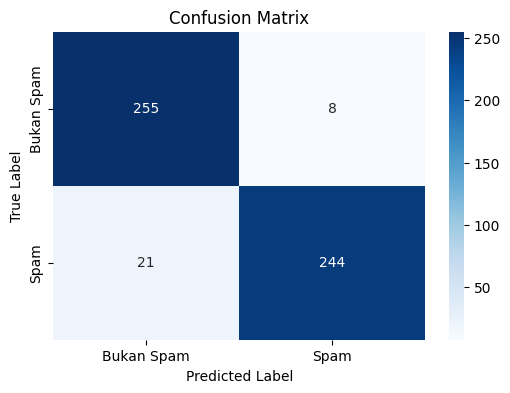

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan dengan seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Bukan Spam", "Spam"], yticklabels=["Bukan Spam", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [19]:
def predict(text):
    text = preprocessing(text)
    tokens = text.split()
    ids = [word2idx.get(word, 0) for word in tokens[:max_len]]
    ids += [0] * (max_len - len(ids))
    input_tensor = torch.tensor([ids])

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = (output > 0.5).float().item()

    return "Spam" if pred == 1.0 else "Bukan Spam"

# Contoh

print(predict("Transfer uang sekarang juga ke rekening ini!"))
print(predict("Selamat! Anda telah memenangkan undian jutaan rupiah, klik di sini untuk klaim hadiah Anda sekarang!"))
print(predict("Posisi mesin pencari menjadi daftar pertama di mesin pencari teratas segera. Perusahaan kami sekarang akan menempatkan bisnis apa pun dengan situs web yang memenuhi syarat secara permanen di bagian atas mesin pencari utama yang dijamin tidak akan pernah bergerak (mis: yahoo !, msn, alta vista, dll.). Promosi ini mencakup lalu lintas tanpa batas dan tidak akan bertahan lama. Jika Anda tertarik untuk dijamin posisi pertama di mesin pencari teratas dengan biaya promosi, silakan hubungi kami segera untuk mengetahui apakah Anda memenuhi syarat melalui email di SearchL 1 @ Telefonica. net. PE itu sangat penting untuk memasukkan URL jika Anda tertarik untuk mempromosikan! ! ! Ini bukan pembayaran per klik. Contoh akan diberikan. Promosi ini hanya berlaku di AS dan Kanada. Hormat kami, spesialis penempatan mesin pencari jika Anda ingin dihapus dari daftar ini, harap tanggapi alamat email berikut dan ketik kata ""hapus"" di baris subjek Anda: cari 6 @ speedy. com. pe"))
print(predict("halo aku sore isri dari masa depan"))


Spam
Spam
Spam
Bukan Spam


In [ ]:
torch.save(model.state_dict(), 'model.pt') # save Model